In [1]:
import torch
import matplotlib.pyplot as plt
from skripsi_program import (
    Burgers,
    FourierBasis,
    to_complex_coeff,
    to_real_coeff,
    StandardScaler,
    SpectralSVR,
    Basis,
    LSSVR,
    get_metrics,
)
from notebooks.utils import save_to_pgf
import pandas as pd
from torchmetrics.functional import mean_squared_error

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
        "figure.constrained_layout.use": True,
    }
)

In [3]:
def get_input_output(
    u: Basis, f: Basis, time_res: slice, sample_size=-1, generator=None
):
    # get values at time resolution
    spatial_modes = u.to_time_dependent().modes[0]
    spatial_res = slice(0, u.periods[1], spatial_modes)
    res = (time_res, spatial_res)

    u_val = u.get_values(res=res)
    # ut_val = u.grad(0).get_values(res=res)
    f_val = f.get_values(res=res)
    # get the coefficients at the time resolution
    u_coeff = u.transform(u_val.flatten(0, 1)).unflatten(0, u_val.shape[:2])
    # ut_coeff = u.transform(ut_val.flatten(0, 1)).unflatten(0, ut_val.shape[:2])
    f_coeff = u.transform(f_val.flatten(0, 1)).unflatten(0, f_val.shape[:2])
    # merge sample and time dimension
    # future time step diff
    # dun = ut_coeff[:, 1:].flatten(0, 1)
    dun = (u_coeff[:, 1:] - u_coeff[:, :-1]).flatten(0, 1)
    # current time step
    uc = u_coeff[:, :-1].flatten(0, 1)
    fn = f_coeff[:, :-1].flatten(0, 1)
    # merge all spatial coefficient dimensions and convert to real valued coefficients
    uc_flat = to_real_coeff(uc.flatten(1))
    fn_flat = to_real_coeff(fn.flatten(1))
    x = torch.concat((uc_flat, fn_flat), dim=1)
    # x = uc_flat
    y = to_real_coeff(dun.flatten(1))
    if sample_size >= 0 and sample_size < len(x):
        sample_size = min(len(x), sample_size)
        sample_index = torch.randperm(sample_size, generator=generator)[:sample_size]
        x = x[sample_index]
        y = y[sample_index]
    return x, y

In [23]:
def u_exact(x: torch.Tensor, t: torch.Tensor, nu: float = 0.01, c: float = 2.0):
    # use p. 705-706 Partial Differential Equations and Solitary Waves Theory, Abdul-Majid Wazwaz
    # eq 1.5 doi: 10.1090/QAM/306736
    # doi: 10.1002/cnm.850
    if t.ndim == 1:
        t = t.unsqueeze(1)
    pi = torch.pi
    pi_x = pi * x
    u = (2 * nu * pi * pi_x.sin()) / (c * t.mul(pi**2 * nu).exp() + pi_x.cos())
    return u


def get_rollout(
    model: SpectralSVR,
    u: Basis,
    f: Basis,
    time_res: slice,
    scaler: StandardScaler,
):
    x_exact, y_exact = get_input_output(u, f, time_res)
    modes2 = y_exact.shape[1]
    # fig, ax = plt.subplots()
    # im = ax.imshow(
    #     FourierBasis.inv_transform(to_complex_coeff(x_exact[:, :modes2])).real,
    #     aspect="auto",
    # )
    # fig.colorbar(im, ax=ax)
    y_pred = []
    uc = x_exact[0:1]
    dt = (time_res.stop - time_res.start) / (time_res.step - 1)
    dun = model.svr.predict(scaler.transform(uc))
    y_pred.append(dun)
    for i in range(1, len(y_exact)):
        uc = torch.cat(
            (dun + uc[:, :modes2], x_exact[i : i + 1, modes2:]),
            # (dt * dun + uc[:, :modes2], x_exact[i : i + 1, modes2:]),
            dim=1,
        )
        # uc = x_exact[i : i + 1]
        dun = model.svr.predict(scaler.transform(uc))
        y_pred.append(dun)

    y_pred = to_complex_coeff(torch.cat(y_pred, dim=0))
    y_exact = to_complex_coeff(y_exact)

    u_init = to_complex_coeff(x_exact[0:1, :modes2])
    u_pred = y_pred.cumsum(0) + u_init
    y_pred = torch.cat((u_init, u_pred), dim=0)
    u_target = y_exact.cumsum(0) + u_init
    y_pred = torch.cat((u_init, u_target), dim=0)
    return (
        u_pred,
        u_target,
    )


def plot_rollout(
    model: SpectralSVR,
    u: Basis,
    f: Basis,
    time_res: slice,
    spatial_res: slice,
    scaler: StandardScaler,
    nu: float,
    label: str,
):
    u_pred, u_target = get_rollout(model, u[0], f[0], time_res, scaler)

    spectral_metrics = get_metrics(
        to_real_coeff(u_pred),
        to_real_coeff(u_target),
    )

    u_pred = FourierBasis.inv_transform(
        to_complex_coeff(u_pred), res=(spatial_res,)
    ).real
    u_target = FourierBasis.inv_transform(
        to_complex_coeff(u_target), res=(spatial_res,)
    ).real

    function_metrics = get_metrics(u_pred, u_target)
    vmax = max(u_pred.max().item(), u_target.max().item())
    vmin = min(u_pred.min().item(), u_target.min().item())
    # symetric vlim
    vlim = max(abs(vmax), abs(vmin))
    vmax = vlim
    vmin = -vlim
    extent = (
        spatial_res.start,
        spatial_res.stop,
        time_res.start,
        time_res.stop,
    )
    xlim = (
        spatial_res.start,
        spatial_res.stop,
    )
    ylim = (
        time_res.start,
        time_res.stop,
    )

    # pred
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        u_pred,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_pred_{nu}.pgf", plt=fig)
    # target
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        u_target,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_target_{nu}.pgf", plt=fig)
    # diff
    diff = u_target - u_pred
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        diff,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_diff_{nu}.pgf", plt=fig)

    return (spectral_metrics, function_metrics)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_18872\2150707914.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 3))


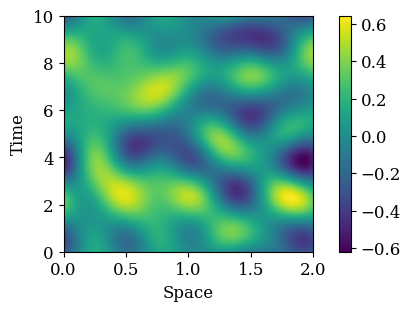

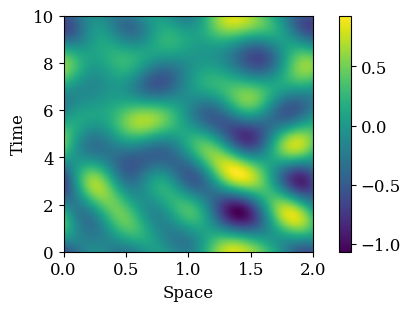

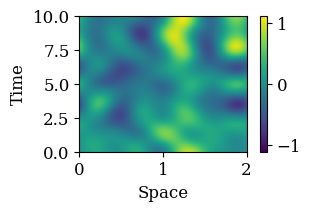

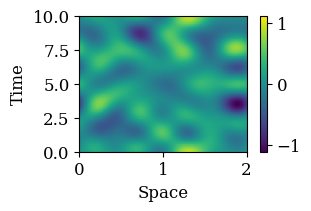

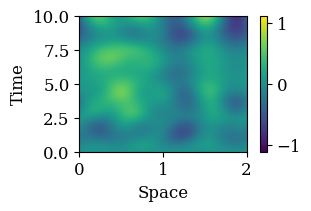

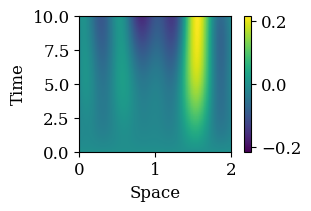

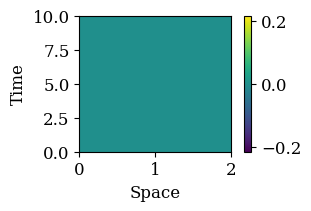

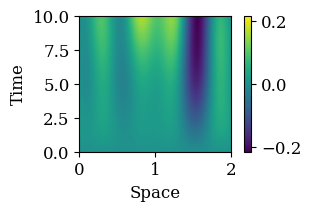

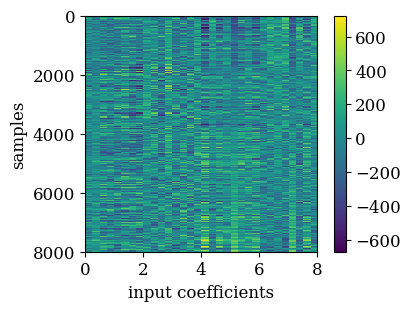

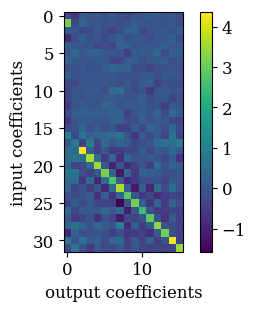

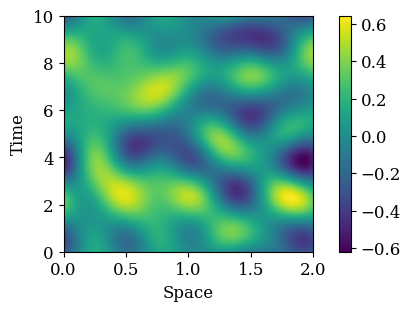

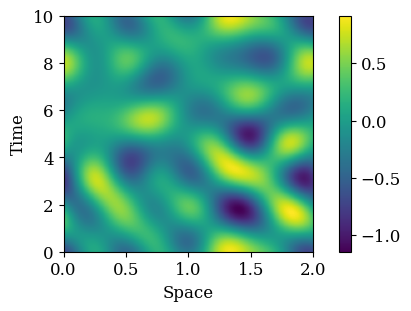

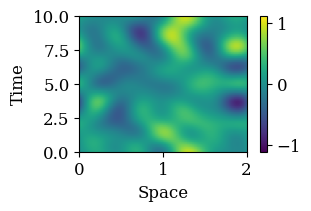

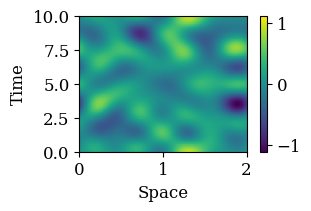

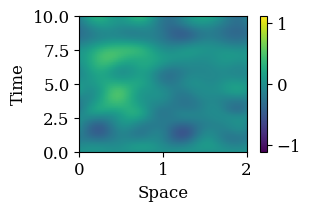

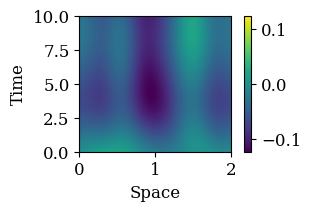

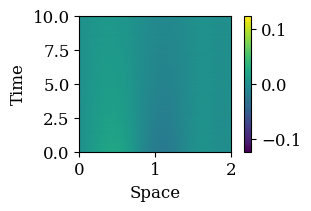

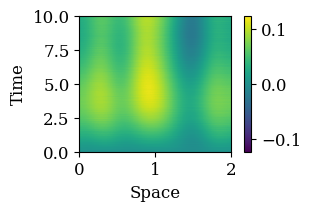

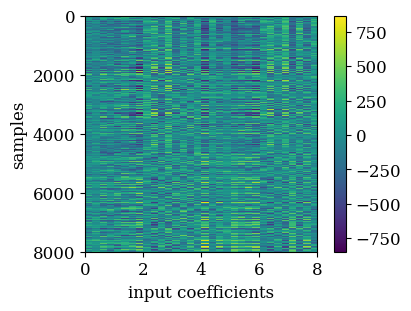

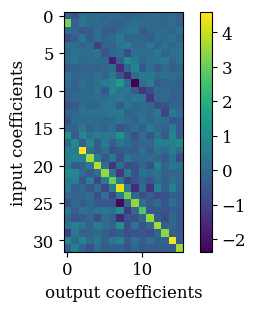

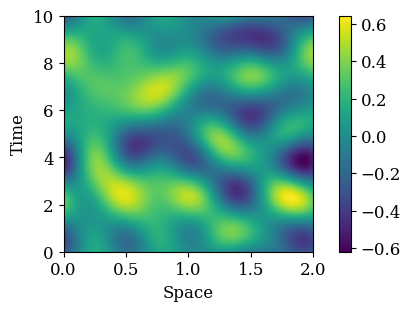

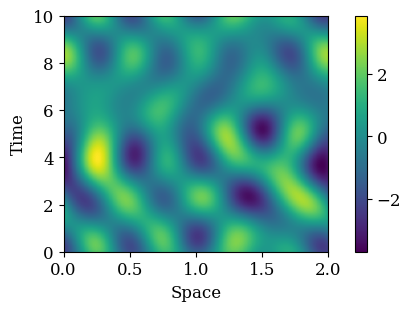

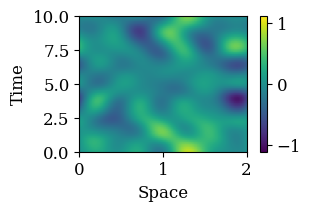

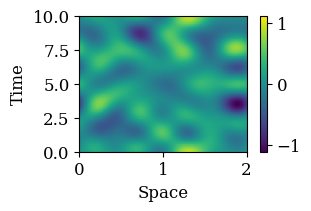

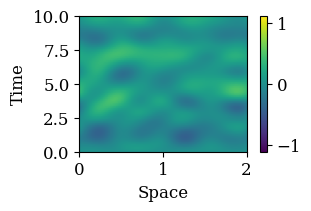

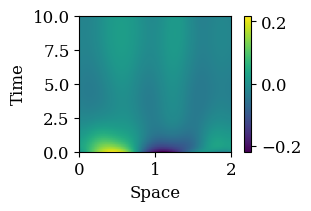

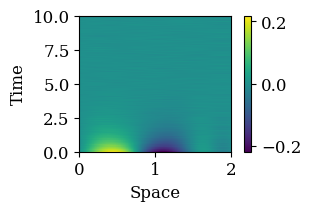

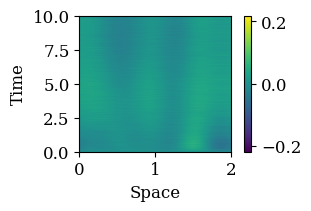

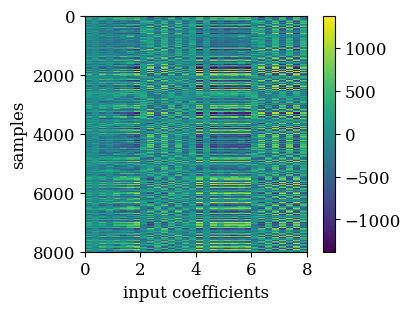

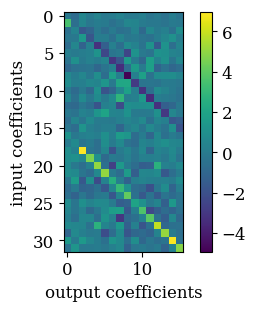

In [24]:
time_domain = slice(0.0, 10.0, 2000)
space_domain = slice(0.0, 2.0, 400)
periods = (time_domain.stop - time_domain.start, space_domain.stop - space_domain.start)
problem = Burgers()
# nu = 0
# nu_values = [0.01]
nu_values = [0.0, 0.01, 0.1]
noise_level = 0.1
# noise_levels = [0.05, 0.1, 0.5]
# noise_levels = [0.0]
n = 500
modes = (8, 8)
spatial_res = space_domain
nt = 200
c = 3.0
time_res = slice(time_domain.start, time_domain.stop, nt)
space_period = space_domain.stop - space_domain.start
data_metrics = {}
spectral_results = {}
function_results = {}
rollout_spectral_results = {}
rollout_function_results = {}
exact_spectral_results = {}
exact_function_results = {}
sigma_values = {}
data_fig = []
data_ax = []
interp_fig = []
interp_ax = []
for i, nu in enumerate(nu_values):
    label = f"{nu}"
    generator = torch.Generator().manual_seed(42)
    u_rand, f_rand = problem.generate(
        basis=FourierBasis,
        n=n,
        modes=modes,
        nu=nu,
        u0="random",
        f="random",
        generator=generator,
        time_domain=time_domain,
        space_domain=space_domain,
        time_dependent_coeff=False,
    )
    # for i, noise_level in enumerate(noise_levels):
    # label = f"{noise_level*100}%"

    # add noise
    u_noisy = u_rand.perturb(std_ratio=noise_level, generator=generator)
    f_noisy = f_rand.perturb(std_ratio=noise_level, generator=generator)

    fig, ax = plt.subplots(figsize=(4, 3))
    im = u_noisy.plot(i=0, plt=ax)
    fig.colorbar(im, ax=ax)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    data_fig.append(fig)
    data_ax.append(ax)
    save_to_pgf(f"burgers_solution_{nu}.pgf", plt=fig)

    fig, ax = plt.subplots(figsize=(4, 3))
    im = f_noisy.plot(i=0, plt=ax)
    fig.colorbar(im, ax=ax)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    data_fig.append(fig)
    data_ax.append(ax)
    save_to_pgf(f"burgers_forcing_{nu}.pgf", plt=fig)

    # Split data by function sample
    n_train = int(0.8 * n)
    x_train, y_train = get_input_output(
        u_noisy[:n_train],
        f_noisy[:n_train],
        time_res=time_res,
        generator=generator,
        sample_size=8000,
    )

    x_test, y_test = get_input_output(
        u_noisy[n_train:],
        f_noisy[n_train:],
        time_res=time_res,
        generator=generator,
        sample_size=2000,
    )

    # scale input data
    scaler = StandardScaler().fit(x_train)
    input_train = scaler.transform(x_train)
    output_train = y_train
    input_test = scaler.transform(x_test)
    output_test = y_test

    # test if the output is trivially computed from the inputs
    # previous_time_step = to_real_coeff(x_train[:, : y_train.shape[1]]).contiguous()
    # next_time_step = to_real_coeff(
    #     y_train[:]
    # ).contiguous()
    # data_metrics = {
    #     **data_metrics,
    #     nu_label: get_metrics(next_time_step, previous_time_step),
    # }
    # Training
    model = SpectralSVR(
        FourierBasis(periods=space_period),
        svr=LSSVR(C=1.0),
    )
    model.train(input_train, output_train)
    sigma_values = {
        **sigma_values,
        label: model.svr.kernel_params["sigma"].item(),
    }
    # Testing
    test_metrics = model.test(input_test, output_test)
    spectral_results = {
        **spectral_results,
        label: {
            **test_metrics["spectral"],
        },
    }
    function_results = {
        **function_results,
        label: {
            **test_metrics["function value"],
        },
    }
    # rollout testing
    u = u_noisy[-1]
    f = f_noisy[-1]
    rollout_metrics = plot_rollout(
        model, u, f, time_res, spatial_res, scaler, nu, "rollout"
    )
    rollout_spectral_results = {
        **rollout_spectral_results,
        label: {
            **rollout_metrics[0],
        },
    }
    rollout_function_results = {
        **rollout_function_results,
        label: {
            **rollout_metrics[1],
        },
    }
    # exact testing
    x = torch.linspace(space_domain.start, space_domain.stop, modes[1])
    t = torch.linspace(time_domain.start, time_domain.stop, nt)
    u_val = u_exact(x, t, nu, c)
    u = FourierBasis(
        FourierBasis.transform(u_val).unsqueeze(0), periods=periods, time_dependent=True
    ).perturb(std_ratio=noise_level, generator=generator)
    f = FourierBasis.generate(
        1, (modes[1], 1), periods=periods, value_type="zero"
    ).perturb(std_ratio=noise_level, generator=generator)
    exact_metrics = plot_rollout(
        model, u, f, time_res, spatial_res, scaler, nu, "exact"
    )
    exact_spectral_results = {
        **exact_spectral_results,
        label: {
            **exact_metrics[0],
        },
    }
    exact_function_results = {
        **exact_function_results,
        label: {
            **exact_metrics[1],
        },
    }
    # interpretation
    tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
    interp_fig.append(tmp_fig)
    interp_ax.append(tmp_ax)
    fig_index = 2 * i
    corr = model.svr.get_correlation_image().cpu()
    sorted = output_train.real[:, 4].sort()
    im = interp_ax[fig_index].imshow(
        corr[sorted.indices.cpu(), :],
        interpolation="none",
        aspect="auto",
        extent=(0, modes[0], corr.shape[0], 0),
    )
    interp_ax[fig_index].set_ylabel("samples")
    interp_ax[fig_index].set_xlabel("input coefficients")
    interp_fig[fig_index].colorbar(im, ax=interp_ax[fig_index])
    save_to_pgf(f"burgers_ci_{nu}.pgf", plt=interp_fig[fig_index])

    tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
    interp_fig.append(tmp_fig)
    interp_ax.append(tmp_ax)
    fig_index = 2 * i + 1
    p_mat = model.svr.get_p_matrix().cpu()
    im = interp_ax[fig_index].imshow(p_mat[:, :], interpolation="none", aspect="equal")
    interp_ax[fig_index].set_xlabel("output coefficients")
    interp_ax[fig_index].set_ylabel("input coefficients")
    interp_fig[fig_index].colorbar(im, ax=interp_ax[2 * i + 1])
    save_to_pgf(f"burgers_pm_{nu}.pgf", plt=interp_fig[fig_index])

In [25]:
sigma_values

{'0.0': 5.657207489013672, '0.01': 5.657207489013672, '0.1': 5.657207489013672}

In [26]:
# data_results_df = pd.DataFrame(data_metrics).T
# data_results_df.index.name="\(\nu \)"
# data_results_df.style.format(precision=2)#.to_latex("tmp.tex")

In [17]:
spectral_results_df = pd.DataFrame(spectral_results).T
spectral_results_df.index.name = "\(\nu \)"
# spectral_results_df.style.format(precision=2).to_latex(
spectral_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)

In [18]:
function_results_df = pd.DataFrame(function_results).T
function_results_df.index.name = "\(\nu \)"
# function_results_df.style.format(precision=2).to_latex(
function_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)

In [32]:
rollout_spectral_results_df = pd.DataFrame(rollout_spectral_results).T
rollout_spectral_results_df.index.name = "\(\nu \)"
rollout_spectral_results_df.style.format(precision=2).to_latex(
# rollout_spectral_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)

In [30]:
rollout_function_results_df = pd.DataFrame(rollout_function_results).T
rollout_function_results_df.index.name = "\(\nu \)"
# rollout_function_results_df.style.format(precision=2).to_latex(
rollout_function_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)

In [33]:
exact_spectral_results_df = pd.DataFrame(exact_spectral_results).T
exact_spectral_results_df.index.name = "\(\nu \)"
# exact_spectral_results_df.style.format(precision=2).to_latex(
exact_spectral_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)

In [34]:
exact_function_results_df = pd.DataFrame(exact_function_results).T
exact_function_results_df.index.name = "\(\nu \)"
# exact_function_results_df.style.format(precision=2).to_latex(
exact_function_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)